In [16]:
import os, glob, re, ast
import pandas as pd
import matplotlib.pyplot as plt

# Resolve input directory (try sibling first)
CANDIDATE_IN_DIRS = [
    "EDA Completed Data",          # same folder
    "../EDA Completed Data",       # sibling (typical in your structure)
    "../../EDA Completed Data",    # two levels up, just in case
]
IN_DIR = next((p for p in CANDIDATE_IN_DIRS if os.path.isdir(p)), None)
if IN_DIR is None:
    raise FileNotFoundError("Couldn't find 'EDA Completed Data' in expected locations.")

# Save outputs in the SAME folder as this notebook (current working directory)
OUT_DIR = "."
MERGED_CSV = os.path.join(OUT_DIR, "all_subreddits_merged.csv")

print(f"Reading from: {os.path.abspath(IN_DIR)}")
print(f"Saving to:    {os.path.abspath(OUT_DIR)}")

Reading from: /Users/tusharbansal/Study (UoA)/Trimester 5/Research Project A/Code/EDA Code/EDA Completed Data
Saving to:    /Users/tusharbansal/Study (UoA)/Trimester 5/Research Project A/Code/EDA Code/Merge EDA


In [17]:
def infer_subreddit_from_filename(path: str) -> str:
    """Infer subreddit name from filename if the column is missing."""
    base = os.path.splitext(os.path.basename(path))[0]
    base = re.sub(r"filtered[_-]?cleaned[_-]?|eda[_-]?completed|posts?", "", base, flags=re.I)
    base = re.sub(r"^[_\\-\\s]+|[_\\-\\s]+$", "", base)  # trim
    base = re.sub(r"__+", "_", base)
    return base or "unknown"

def safe_token_count(row) -> int:
    """Prefer tokens column; otherwise count words in clean_text."""
    if "tokens" in row and pd.notna(row["tokens"]):
        val = row["tokens"]
        if isinstance(val, list):
            return len(val)
        if isinstance(val, str):
            s = val.strip()
            if s.startswith("[") and s.endswith("]"):
                try:
                    lst = ast.literal_eval(s)
                    if isinstance(lst, list):
                        return len(lst)
                except Exception:
                    pass
            return len(val.split())
    text = row.get("clean_text", "")
    return len(str(text).split())

In [18]:
csv_paths = sorted(glob.glob(os.path.join(IN_DIR, "*.csv")))
if not csv_paths:
    raise FileNotFoundError(f"No CSVs found in: {IN_DIR}")
print(f"Found {len(csv_paths)} CSV file(s):")
for p in csv_paths:
    print(" -", os.path.basename(p))

Found 21 CSV file(s):
 - adhd_eda_completed.csv
 - adhd_parenting_eda_completed.csv
 - adhd_programmers_eda_completed.csv
 - alcoholism_eda_completed.csv
 - anxiety_depression_eda_completed.csv
 - bpd_eda_completed.csv
 - dbtselfhelp_eda_completed.csv
 - depression_eda_completed.csv
 - depression_help_eda_completed.csv
 - healthanxiety_eda_completed.csv
 - lonely_eda_completed.csv
 - mentalhealth_eda_completed.csv
 - mentalhealthsupport_eda_completed.csv
 - offmychest_eda_completed.csv
 - postpartum_depression_eda_completed.csv
 - ptsd_eda_completed.csv
 - sanctioned_suicide_eda_completed.csv
 - social_anxiety_eda_completed.csv
 - suicide_bereavement_eda_completed.csv
 - suicide_watch_eda_completed.csv
 - trauma_toolbox_eda_completed.csv


In [19]:
frames = []
for p in csv_paths:
    df = pd.read_csv(p)
    if "subreddit" not in df.columns:
        df["subreddit"] = infer_subreddit_from_filename(p)
    df["subreddit"] = df["subreddit"].astype(str)
    df["source_file"] = os.path.basename(p)
    frames.append(df)

merged = pd.concat(frames, ignore_index=True)

# Optional de-duplication by post text if available
if "post_text" in merged.columns:
    before = len(merged)
    merged.drop_duplicates(subset="post_text", inplace=True)
    after = len(merged)
    print(f"Deduplicated by post_text: {before - after} rows removed")

# Add word counts for quick stats
merged["word_count"] = merged.apply(safe_token_count, axis=1)

merged.to_csv(MERGED_CSV, index=False)
print(f"✅ Merged and saved as ONE file → {MERGED_CSV}")
print(f"Total rows: {len(merged):,}")
merged.head(3)

Deduplicated by post_text: 542 rows removed
✅ Merged and saved as ONE file → ./all_subreddits_merged.csv
Total rows: 95,276


,score,date,title,author,url,post_text,subreddit,clean_text,tokens,word_count,source_file
0,1,2024-12-12,Does Strattera work for anyone?,crabgal,https://www.reddit.com/r/ADHD/comments/1hcl16z...,My psychiatrist recently decided to switch me ...,ADHD,psychiatrist decided switch concerta strattera...,"['psychiatrist', 'decided', 'switch', 'concert...",40,adhd_eda_completed.csv
1,2,2024-12-12,How can I become a better student and stop fee...,Thirdworldnerd02,https://www.reddit.com/r/ADHD/comments/1hc3g0n...,"I’ve had some trouble at uni recently, I spoke...",ADHD,’ trouble uni spoke favorite teacher another t...,"['’', 'trouble', 'uni', 'spoke', 'favorite', '...",130,adhd_eda_completed.csv
2,7,2024-12-12,able to read social cues fine but not know how...,brohno,https://www.reddit.com/r/ADHD/comments/1hc30d4...,"i always thought i was fine socially, i was sh...",ADHD,socially shy growing usually quiet situation n...,"['socially', 'shy', 'growing', 'usually', 'qui...",116,adhd_eda_completed.csv


In [5]:
counts = merged["subreddit"].value_counts().rename_axis("subreddit").reset_index(name="posts")
counts["share_%"] = (counts["posts"] / counts["posts"].sum() * 100).round(2)

COUNTS_CSV = os.path.join(OUT_DIR, "posts_per_subreddit.csv")
counts.to_csv(COUNTS_CSV, index=False)

print("\nPosts per subreddit (top 20):")
print(counts.head(20).to_string(index=False))
print(f"\nSaved summary → {COUNTS_CSV}")


Posts per subreddit (top 20):
            subreddit  posts  share_%
   SuicideBereavement   6387     6.70
           depression   6257     6.57
                  BPD   6230     6.54
           offmychest   6215     6.52
        socialanxiety   6001     6.30
                 ptsd   5991     6.29
         SuicideWatch   5886     6.18
         mentalhealth   5825     6.11
           alcoholism   5694     5.98
    AnxietyDepression   5693     5.98
                 ADHD   5659     5.94
  MentalHealthSupport   5593     5.87
      depression_help   5492     5.76
        HealthAnxiety   5188     5.45
               lonely   4802     5.04
        ADHDparenting   2144     2.25
     ADHD_Programmers   1869     1.96
Postpartum_Depression   1803     1.89
        traumatoolbox   1532     1.61
    SanctionedSuicide    580     0.61

Saved summary → ./posts_per_subreddit.csv


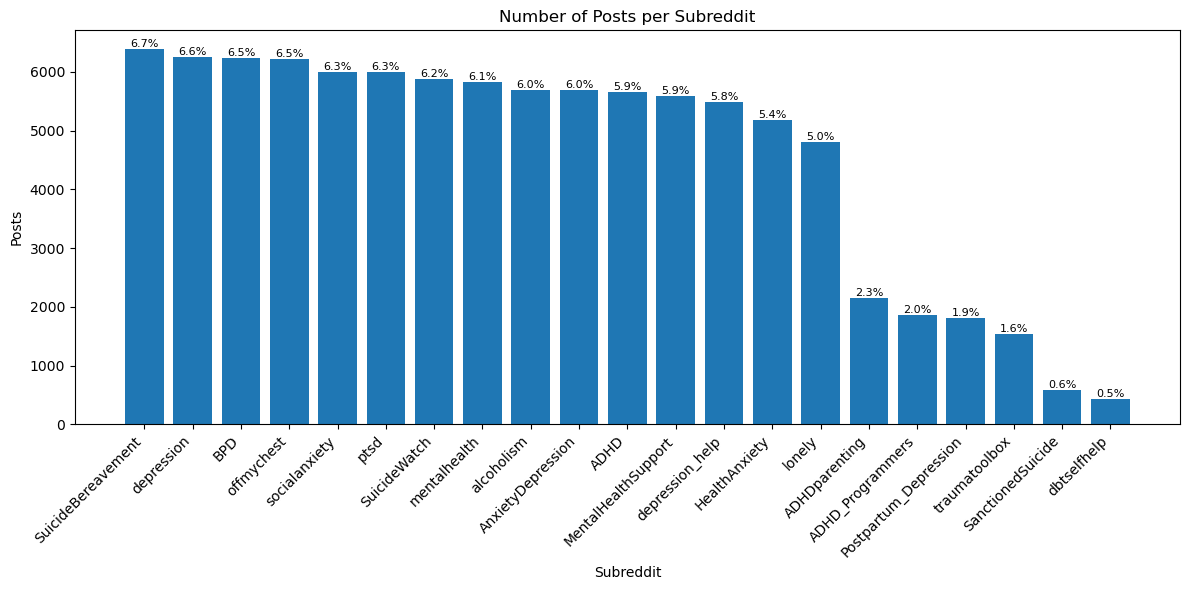

Saved plot → ./posts_per_subreddit_bar.png


In [6]:
plt.figure(figsize=(12, 6))
plt.bar(counts["subreddit"], counts["posts"])
plt.xticks(rotation=45, ha="right")
plt.title("Number of Posts per Subreddit")
plt.xlabel("Subreddit")
plt.ylabel("Posts")
plt.tight_layout()

# Label bars with share %
total_posts = counts["posts"].sum()
for x, y in zip(range(len(counts)), counts["posts"]):
    share = (y / total_posts) * 100
    plt.text(x, y, f"{share:.1f}%", ha="center", va="bottom", fontsize=8)

PLOT_COUNTS = os.path.join(OUT_DIR, "posts_per_subreddit_bar.png")
plt.savefig(PLOT_COUNTS, dpi=200, bbox_inches="tight")
plt.show()
print(f"Saved plot → {PLOT_COUNTS}")

In [9]:
stats = (
    merged.groupby("subreddit")["word_count"]
    .agg(["count", "mean", "median", "std"])
    .reset_index()
    .rename(columns={"count":"posts", "mean":"avg_words", "median":"median_words"})
)
stats["avg_words"] = stats["avg_words"].round(2)
stats["median_words"] = stats["median_words"].round(0)

STATS_CSV = os.path.join(OUT_DIR, "wordcount_stats_by_subreddit.csv")
stats.to_csv(STATS_CSV, index=False)
print("\nWord-count stats (top 12 by avg_words):")
print(stats.sort_values("avg_words", ascending=False).head(12).to_string(index=False))
print(f"\nSaved stats → {STATS_CSV}")


Word-count stats (top 12 by avg_words):
            subreddit  posts  avg_words  median_words        std
           offmychest   6215      94.56          67.0 100.982936
        traumatoolbox   1532      92.27          65.0 107.720436
Postpartum_Depression   1803      75.10          58.0  65.654572
                 ptsd   5991      72.93          51.0  86.512866
  MentalHealthSupport   5593      72.87          51.0  78.010329
        ADHDparenting   2144      70.67          55.0  61.862570
   SuicideBereavement   6387      67.30          48.0  68.032195
     ADHD_Programmers   1869      65.96          44.0  73.129076
         mentalhealth   5825      63.00          47.0  59.666602
                  BPD   6230      61.05          46.0  51.080164
      depression_help   5492      59.34          43.0  57.402811
           alcoholism   5694      58.48          40.0  67.516102

Saved stats → ./wordcount_stats_by_subreddit.csv


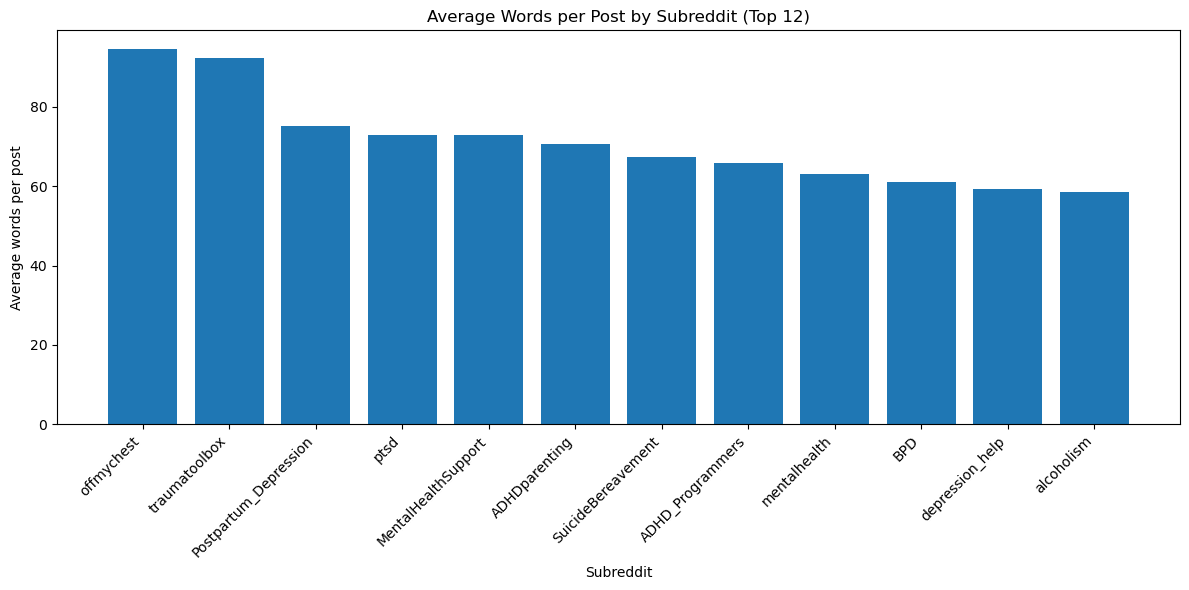

Saved plot → ./avg_words_per_post_top12.png


In [10]:
# Chart: average words per post (top 12)
top12 = stats.sort_values("avg_words", ascending=False).head(12)
plt.figure(figsize=(12, 6))
plt.bar(top12["subreddit"], top12["avg_words"])
plt.xticks(rotation=45, ha="right")
plt.title("Average Words per Post by Subreddit (Top 12)")
plt.xlabel("Subreddit")
plt.ylabel("Average words per post")
plt.tight_layout()

PLOT_AVG = os.path.join(OUT_DIR, "avg_words_per_post_top12.png")
plt.savefig(PLOT_AVG, dpi=200, bbox_inches="tight")
plt.show()
print(f"Saved plot → {PLOT_AVG}")

In [11]:
# Cell 8 — Class imbalance table (share% + cumulative)
class_imbalance = counts.copy()
class_imbalance["cumulative_%"] = class_imbalance["share_%"].cumsum().round(2)

imbalance_csv = os.path.join(OUT_DIR, "class_imbalance_table.csv")
class_imbalance.to_csv(imbalance_csv, index=False)

print("\nClass imbalance table:")
print(class_imbalance.to_string(index=False))
print(f"\n📄 Saved: {imbalance_csv}")



Class imbalance table:
            subreddit  posts  share_%  cumulative_%
   SuicideBereavement   6387     6.70          6.70
           depression   6257     6.57         13.27
                  BPD   6230     6.54         19.81
           offmychest   6215     6.52         26.33
        socialanxiety   6001     6.30         32.63
                 ptsd   5991     6.29         38.92
         SuicideWatch   5886     6.18         45.10
         mentalhealth   5825     6.11         51.21
           alcoholism   5694     5.98         57.19
    AnxietyDepression   5693     5.98         63.17
                 ADHD   5659     5.94         69.11
  MentalHealthSupport   5593     5.87         74.98
      depression_help   5492     5.76         80.74
        HealthAnxiety   5188     5.45         86.19
               lonely   4802     5.04         91.23
        ADHDparenting   2144     2.25         93.48
     ADHD_Programmers   1869     1.96         95.44
Postpartum_Depression   1803     1.89   